In [1]:
#https://aidanrussellcom.wordpress.com/2019/01/14/pystan-tutorial-1/

In [2]:
# TODO try np.exp or x**2, etc for prop
# TODO try larger dataset

In [5]:
import numpy as np
import pandas as pd
import stan as ps
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
from utils import get_data
np.random.seed(2024)
train, test = get_data(filepath="processed_data/full_data_secs.csv", size_train=1000, size_test=800)
# train = train[train["dist"] == "10K"]

# train["prop2"] = np.exp(train["prop"])
# test["prop2"] = np.exp(test["prop"])

train["prop2"] = train["prop"] ** 2
test["prop2"] = test["prop"] ** 2
train.to_csv("train.csv")
test.to_csv("test.csv")

In [4]:
ols_model = smf.ols(formula="finish ~ total_pace + curr_pace + prop", data=train)  # np.exp(prop)
ols_fit = ols_model.fit()
print(ols_fit.summary())

                            OLS Regression Results                            
Dep. Variable:                 finish   R-squared:                       0.943
Model:                            OLS   Adj. R-squared:                  0.943
Method:                 Least Squares   F-statistic:                 4.403e+04
Date:                Wed, 19 Mar 2025   Prob (F-statistic):               0.00
Time:                        18:33:10   Log-Likelihood:                 4710.1
No. Observations:                8000   AIC:                            -9412.
Df Residuals:                    7996   BIC:                            -9384.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.2486      0.010    -24.176      0.0

In [5]:
# ols_fit.get_prediction(test).summary_frame(alpha=0.05)

In [6]:
# ! python pystan_code.py #2.5mins total: train=500

In [6]:
import pandas as pd
# stan_results = pd.read_csv("stan_results/ps_result.csv") #stan_results = pd.read_csv("ps_result5K.csv")

# marks = ["5K", "10K", "15K", "20K", "25K", "30K", "35K", "40K"]
# sep_results = {mk: pd.read_csv(f"stan_results/ps_result{mk}.csv") for mk in marks}
# stan_results.describe()

marks = ["5K", "10K", "15K", "20K", "25K", "30K", "35K", "40K"]
stan_results1 = pd.read_csv("stan_results/bayes1/ps_result.csv")
stan_results2 = pd.read_csv("stan_results/bayes2/ps_result.csv")

sep_results1 = {mk: pd.read_csv(f"stan_results/bayes1/ps_result{mk}.csv") for mk in marks}
sep_results2 = {mk: pd.read_csv(f"stan_results/bayes2/ps_result{mk}.csv") for mk in marks}
stan_results2.describe()

,draws,lp__,accept_stat__,stepsize__,treedepth__,n_leapfrog__,divergent__,energy__,alpha,beta.1,beta.2,beta.3,sigma
count,4000.000000,4000.000000,4000.000000,4000.000000,4000.00000,4000.000000,4000.0,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000
mean,1999.500000,12057.038265,0.937644,0.026028,6.42300,122.984500,0.0,-12054.541702,-0.248759,0.705087,0.290466,0.315215,0.134356
std,1154.844867,1.639153,0.089683,0.001799,1.00091,57.970172,0.0,2.300926,0.010185,0.012866,0.011973,0.006661,0.001102
min,0.000000,12046.192372,0.317368,0.023204,1.00000,1.000000,0.0,-12059.080622,-0.288747,0.663051,0.245798,0.293009,0.130668
25%,999.750000,12056.214245,0.913812,0.025099,6.00000,87.000000,0.0,-12056.217556,-0.255172,0.696452,0.282190,0.310791,0.133599
50%,1999.500000,12057.381755,0.975200,0.026649,7.00000,127.000000,0.0,-12054.905495,-0.248803,0.705364,0.290298,0.315407,0.134331
75%,2999.250000,12058.226318,0.996800,0.027578,7.00000,127.000000,0.0,-12053.264026,-0.241996,0.713959,0.298573,0.319696,0.135099
max,3999.000000,12059.516225,1.000000,0.027612,8.00000,255.000000,0.0,-12042.567338,-0.215513,0.749221,0.332169,0.338122,0.139033


In [7]:
pd.DataFrame([sep_results2[mk][["alpha", "beta.1", "beta.2", "sigma"]].mean() for mk in marks])

,alpha,beta.1,beta.2,sigma
0,-0.253600,1.498219,-0.478779,0.210583
1,-0.174760,-0.315213,1.310351,0.174108
2,-0.136911,-0.158940,1.152171,0.152327
3,-0.013540,0.082077,0.891763,0.123176
4,0.030608,0.317004,0.647901,0.091550
5,0.089950,0.540963,0.428703,0.062082
6,0.063249,0.768970,0.215011,0.037761
7,0.018218,0.928482,0.066630,0.015630


In [8]:
pd.DataFrame([sep_results1[mk][["alpha", "beta.1", "sigma"]].mean() for mk in marks])

,alpha,beta.1,sigma
0,-0.246581,1.017472,0.210085
1,-0.253984,1.019268,0.185635
2,-0.246028,1.019670,0.168658
3,-0.208948,1.015430,0.145445
4,-0.167617,1.009492,0.118736
5,-0.095633,1.001064,0.087563
6,-0.031198,0.996395,0.054008
7,-0.000873,0.997040,0.020848


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


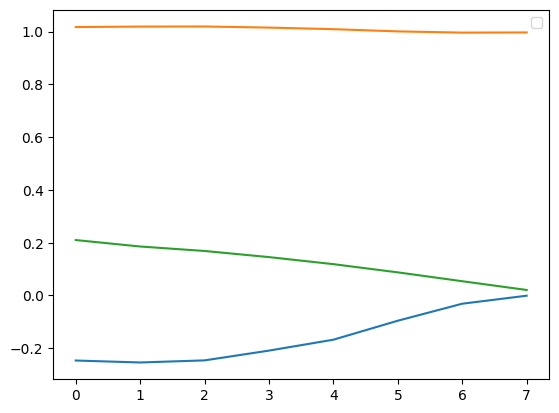

In [9]:
# plt.plot(pd.DataFrame([sep_results2[mk][["alpha", "beta.1", "beta.2", "sigma"]].mean() for mk in marks]))
plt.plot(pd.DataFrame([sep_results1[mk][["alpha", "beta.1", "sigma"]].mean() for mk in marks]))
plt.legend()
# plt.ylim(0, .3)

In [10]:
def full_predictions(test_data, stan_data, feats_lis, beta_lis, name="stan_pred"):
    test_new = test_data.copy()
    d1 = test_new[feats_lis]
    d2 = stan_data[beta_lis].T.copy()
    preds = np.random.normal(stan_data["alpha"] + d1.dot(d2.values), stan_data["sigma"])
    return preds

def get_predictions(test_data, stan_data, feats_lis, beta_lis, name="stan_pred"):
    test_new = test_data.copy()
    d1 = test_new[feats_lis]
    d2 = stan_data[beta_lis].T.copy()
    # preds = (stan_data["alpha"] + d1.dot(d2.values)).mean(axis=1)
    preds = np.random.normal(stan_data["alpha"] + d1.dot(d2.values), stan_data["sigma"]).mean(axis=1)
    test_new[name] = preds
    return test_new

def get_table(test_data, old="stan_pred", new="stan"):
    y_true = (42195 / 60) / test_data["finish"]
    preds = (42195 / 60) / test_data[old]
    extrap = (42195 / 60) / test_data["total_pace"]
    test_data[new] = preds - y_true
    test_data["extrap"] = extrap - y_true
    return test_data

In [11]:
test_pred_t1 = get_predictions(test, stan_results1, feats_lis = ["total_pace", "prop"], beta_lis = ["beta.1", "beta.2"])
test_pred_t2 = get_predictions(test, stan_results2, feats_lis = ["total_pace", "curr_pace", "prop"], beta_lis = ["beta.1", "beta.2", "beta.3"])
test_pred_s1 = pd.concat([get_predictions(test_pred_t1[test_pred_t1["dist"] == mk], sep_results1[mk], 
                    feats_lis = ["total_pace"], beta_lis = ["beta.1"]) for mk in marks])
test_pred_s2 = pd.concat([get_predictions(test_pred_t2[test_pred_t2["dist"] == mk], sep_results2[mk], 
                    feats_lis = ["total_pace", "curr_pace"], beta_lis = ["beta.1", "beta.2"]) for mk in marks])

In [12]:
s_data =pd.DataFrame([[4, 0.2], [3, 0.5]], columns=["total_pace", "prop"])
full_predictions(s_data, stan_results1, feats_lis = ["total_pace", "prop"], beta_lis = ["beta.1", "beta.2"])


array([[3.5211625 , 3.85007733, 3.98849216, ..., 3.84486087, 3.89478691,
        3.53943763],
       [3.14826451, 2.60699502, 2.51898891, ..., 2.86824199, 2.80654053,
        2.94811071]])

In [13]:
test

,id,dist,curr_pace,total_pace,finish,age,gender,year,prop,prop2
28,286805,5K,5.154639,5.154639,5.018435,31,M,2023,0.118497,0.014042
71,286848,5K,4.677268,4.677268,4.851115,29,F,2023,0.118497,0.014042
85,286862,5K,4.897160,4.897160,4.806904,30,M,2023,0.118497,0.014042
120,286897,5K,5.117707,5.117707,4.720855,41,M,2023,0.118497,0.014042
125,286902,5K,4.616805,4.616805,4.707687,23,M,2023,0.118497,0.014042
...,...,...,...,...,...,...,...,...,...,...
208126,312707,40K,1.631321,1.960977,1.956008,27,F,2023,0.947980,0.898665
208138,312719,40K,1.728310,1.967439,1.951665,56,F,2023,0.947980,0.898665
208148,312729,40K,1.693193,1.959728,1.943664,60,M,2023,0.947980,0.898665
208150,312731,40K,1.431434,1.968310,1.942322,64,M,2023,0.947980,0.898665


In [14]:
table = get_table(test_pred_t1).copy()
table["bayes1_sep"] = get_table(test_pred_s1)["stan"]
table["bayes2_sep"] = get_table(test_pred_s2)["stan"]
table["bayes1_stan"] = get_table(test_pred_t1)["stan"]
table["bayes2_stan"] = get_table(test_pred_t2)["stan"]
table

,id,dist,curr_pace,total_pace,finish,age,gender,year,prop,prop2,stan_pred,stan,extrap,bayes1_sep,bayes2_sep,bayes1_stan,bayes2_stan
28,286805,5K,5.154639,5.154639,5.018435,31,M,2023,0.118497,0.014042,4.948263,1.987249,-3.702833,0.432233,0.511506,1.987249,2.817397
71,286848,5K,4.677268,4.677268,4.851115,29,F,2023,0.118497,0.014042,4.468608,12.408953,5.388183,11.105138,10.693737,12.408953,13.328965
85,286862,5K,4.897160,4.897160,4.806904,30,M,2023,0.118497,0.014042,4.691548,3.597226,-2.696350,2.082470,2.183982,3.597226,4.670089
120,286897,5K,5.117707,5.117707,4.720855,41,M,2023,0.118497,0.014042,4.914477,-5.869031,-11.551617,-7.366428,-7.063722,-5.869031,-5.012253
125,286902,5K,4.616805,4.616805,4.707687,23,M,2023,0.118497,0.014042,4.405667,10.240631,2.940617,8.760798,8.734304,10.240631,10.832688
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
208126,312707,40K,1.631321,1.960977,1.956008,27,F,2023,0.947980,0.898665,1.919852,6.770990,-0.910996,0.214030,1.504542,6.770990,9.955284
208138,312719,40K,1.728310,1.967439,1.951665,56,F,2023,0.947980,0.898665,1.921855,5.589223,-2.888940,-1.691571,-1.569328,5.589223,2.110845
208148,312729,40K,1.693193,1.959728,1.943664,60,M,2023,0.947980,0.898665,1.918351,4.774165,-2.965773,-1.777515,-1.344441,4.774165,3.336859
208150,312731,40K,1.431434,1.968310,1.942322,64,M,2023,0.947980,0.898665,1.926549,2.964364,-4.780504,-3.550946,0.240981,2.964364,17.133860


         extrap  bayes1_sep  bayes2_sep  bayes1_stan  bayes2_stan
dist                                                             
5K    18.266615   15.736424   15.751810    16.528944    16.714922
10K   17.293082   13.306966   12.566656    13.316473    12.856229
15K   15.891527   11.559868   10.142669    11.335664    10.662772
20K   13.460085    9.642344    9.678155     9.338140     8.467118
25K   11.258575    8.076614    6.331764     7.698016     6.593157
30K    7.920076    6.047803    4.381177     5.934364     4.679391
35K    4.376820    3.796089    2.756161     4.435624     3.989283
40K    1.179431    1.141627    0.905220     2.608737     4.023170


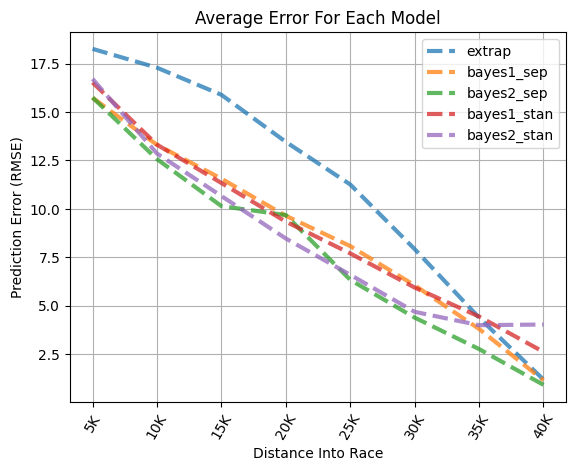

In [15]:
labels = ["extrap", "stan", "stan_sep"]#, "bayes2", "quant1", "quant2"]
labels = ["extrap", "bayes1_sep", "bayes2_sep", "bayes1_stan", "bayes2_stan"]
colors = ["C0", "C1", "C2", "C3", "C4"]
styles = '--'
mks = ["5K", "10K", "15K", "20K", "25K", "30K", "35K", "40K"]
table_group = table.groupby(["dist"])[labels].apply(lambda x: (x ** 2).mean() ** 0.5).loc[mks]
print(table_group)
table_group.plot(label=table_group.columns,  style=styles, linewidth=3, grid=True, alpha=0.75, color=colors)

plt.xlabel("Distance Into Race")
plt.ylabel("Prediction Error (RMSE)")
plt.xticks(rotation=60)
plt.title("Average Error For Each Model")
plt.grid(True)
plt.legend()
# plt.savefig("analysis/all_errors_new1.png", bbox_inches="tight")

In [16]:
full_preds1 =  (42195 / 60) / full_predictions(test, stan_results1, feats_lis = ["total_pace", "prop"], beta_lis = ["beta.1", "beta.2"])
full_preds2 =  (42195 / 60) / full_predictions(test, stan_results2, feats_lis = ["total_pace", "curr_pace", "prop"], beta_lis = ["beta.1", "beta.2", "beta.3"])

full_sep1 = (42195 / 60) / pd.concat([pd.DataFrame(full_predictions(test_pred_t1[test_pred_t1["dist"] == mk], sep_results1[mk], 
                    feats_lis = ["total_pace"], beta_lis = ["beta.1"])) for mk in marks])
full_sep2 = (42195 / 60) / pd.concat([pd.DataFrame(full_predictions(test_pred_t2[test_pred_t2["dist"] == mk], sep_results2[mk], 
            feats_lis = ["total_pace", "curr_pace"], beta_lis = ["beta.1", "beta.2"])) for mk in marks])

full_preds1.shape, full_preds2.shape, full_sep1.shape, full_sep2.shape

((6400, 4000), (6400, 4000), (6400, 4000), (6400, 4000))

In [16]:
# (42195/60) / test["finish"]
full_preds1.max(axis=1) - full_preds1.min(axis=1)#.shape

array([ 29.04541819,  32.1326674 ,  34.81791945, ..., 190.86762139,
       210.89578819, 258.81767686])

In [26]:
full_preds1

array([[150.47991556, 140.82046374, 137.01312736, ..., 141.00592699,
        139.4191107 , 150.31557167],
       [147.70327291, 166.96276242, 170.60548157, ..., 157.33438797,
        159.25030544, 154.79732805],
       [150.39484541, 140.25103597, 143.19493402, ..., 151.41572998,
        149.25547478, 150.14937284],
       ...,
       [345.29916792, 337.87215446, 365.37881591, ..., 386.26430113,
        376.5433068 , 363.64474946],
       [357.74760824, 340.68569436, 388.96758433, ..., 414.40225225,
        341.56873375, 355.83160814],
       [368.43532724, 403.77060128, 448.97923353, ..., 366.52596627,
        361.64737031, 411.10073438]])

<Axes: ylabel='Density'>

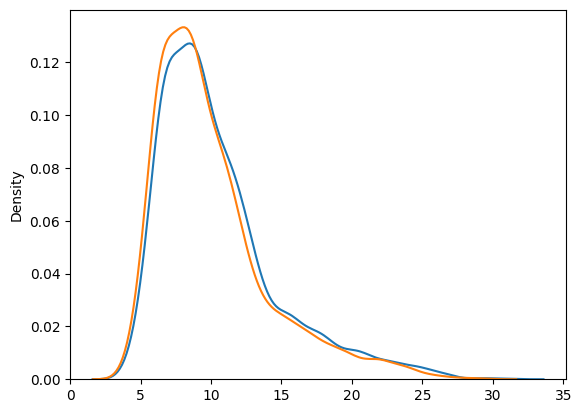

In [17]:
import seaborn as sns
sns.kdeplot(full_preds1.std(axis=1))
sns.kdeplot(full_preds2.std(axis=1))

In [18]:
def add_intervals_to_test(data_tbl, preds1, preds2):#, q1, q2):
    data = data_tbl.copy()
    for conf, lower, upper in [(50, 25, 75), (80, 10, 90), (95, 2.5, 97.5)]:
        test_true = (42195 / 60) / data["finish"]
        b11, b12 = np.percentile(preds1, [lower, upper], axis=1)
        data[f"bayes1-lower{conf}"] = b11
        data[f"bayes1-upper{conf}"] = b12
        data[f"bayes1-size{conf}"] = b12 - b11
        data[f"bayes1-in{conf}"] = (test_true < b12) & (test_true > b11)

        b21, b22 = np.percentile(preds2, [lower, upper], axis=1)
        data[f"bayes2-lower{conf}"] = b21
        data[f"bayes2-upper{conf}"] = b22
        data[f"bayes2-size{conf}"] = b22 - b21
        data[f"bayes2-in{conf}"] = (test_true < b22) & (test_true > b21)

        # q11, q12 = get_quants(train, test, formula="finish ~ total_pace + dist", quantiles=[lower, upper])
        # data[f"quant1-lower{conf}"] = q11
        # data[f"quant1-upper{conf}"] = q12
        # data[f"quant1-size{conf}"] = q12 - q11
        # data[f"quant1-in{conf}"] = (test_true < q12) & (test_true > q11)

        # q21, q22 = get_quants(train, test, formula="finish ~ total_pace + curr_pace + dist", quantiles=[lower, upper])
        # data[f"quant2-lower{conf}"] = q21
        # data[f"quant2-upper{conf}"] = q22
        # data[f"quant2-size{conf}"] = q22 - q21
        # data[f"quant2-in{conf}"] = (test_true < q22) & (test_true > q21)

    return data

In [19]:
# table2 = add_intervals_to_test(table, full_preds1, full_preds2)
table2 = add_intervals_to_test(table, full_sep1, full_sep2)
table2

,id,dist,curr_pace,total_pace,finish,age,gender,year,prop,prop2,...,bayes2-size80,bayes2-in80,bayes1-lower95,bayes1-upper95,bayes1-size95,bayes1-in95,bayes2-lower95,bayes2-upper95,bayes2-size95,bayes2-in95
28,286805,5K,5.154639,5.154639,5.018435,31,M,2023,0.118497,0.014042,...,15.676056,True,129.623187,153.451314,23.828127,True,129.923967,153.396527,23.472559,True
71,286848,5K,4.677268,4.677268,4.851115,29,F,2023,0.118497,0.014042,...,18.930600,False,142.738491,171.375227,28.636735,True,142.671183,172.110167,29.438984,True
85,286862,5K,4.897160,4.897160,4.806904,30,M,2023,0.118497,0.014042,...,16.947730,True,136.255268,162.876083,26.620814,True,136.308222,162.570890,26.262668,True
120,286897,5K,5.117707,5.117707,4.720855,41,M,2023,0.118497,0.014042,...,15.597279,True,130.881272,154.911218,24.029946,True,130.724632,154.351121,23.626489,True
125,286902,5K,4.616805,4.616805,4.707687,23,M,2023,0.118497,0.014042,...,19.030079,True,144.270043,174.345303,30.075260,True,144.618285,174.232452,29.614167,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
208126,312707,40K,1.631321,1.960977,1.956008,27,F,2023,0.947980,0.898665,...,7.361881,True,352.769791,367.650515,14.880724,True,355.404688,366.999806,11.595118,True
208138,312719,40K,1.728310,1.967439,1.951665,56,F,2023,0.947980,0.898665,...,7.358283,True,351.485946,366.605673,15.119727,True,353.117800,364.369262,11.251462,True
208148,312729,40K,1.693193,1.959728,1.943664,60,M,2023,0.947980,0.898665,...,7.425018,True,352.759466,368.309526,15.550060,True,354.940887,366.256305,11.315418,True
208150,312731,40K,1.431434,1.968310,1.942322,64,M,2023,0.947980,0.898665,...,7.625386,True,351.187932,366.165688,14.977756,True,356.532759,368.179289,11.646530,True


In [20]:
from collections import Counter
Counter(table2["bayes1-in50"])

Counter({True: 3445, False: 2955})

<Figure size 4000x4000 with 0 Axes>

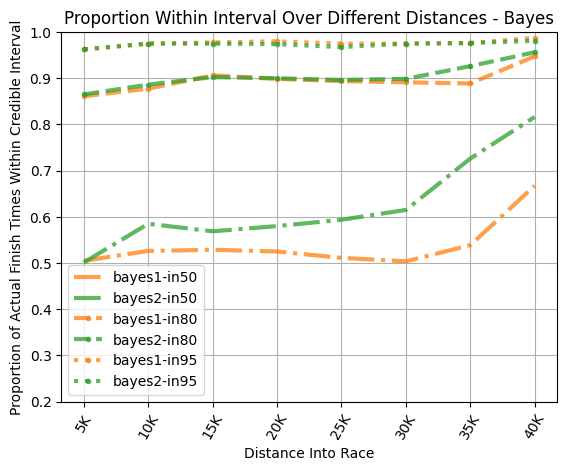

In [21]:
colors = ['C1', 'C2'] * 3
tables = []
for conf, style in [(50, "-."), (80, "--."), (95, ":.")]:
    sublabels = [f"bayes1-in{conf}", f"bayes2-in{conf}"]
    table3 = table2.groupby(["dist"])[sublabels].apply(lambda x: np.sum(x) / len(x)).loc[mks]
    tables.append(table3)

plt.figure(figsize=(40, 40))
big_table = pd.concat(tables, axis=1)
big_table.plot(label=big_table.columns,  style=["-."] * 2 + ["--."] * 2 + [":."] * 2 , linewidth=3, grid=True, alpha=0.75, color=colors)
# plt.ylim(0.2, 1) 
plt.legend(loc="lower center")

plt.xlabel("Distance Into Race")
plt.ylabel("Proportion of Actual Finish Times Within Credible Interval")
plt.xticks(rotation=60)
plt.ylim(0.2, 1)
plt.title("Proportion Within Interval Over Different Distances - Bayes")
plt.grid(True)
plt.legend()
# plt.savefig("analysis/interval_check_bayes.png", bbox_inches="tight")

<Figure size 3000x2000 with 0 Axes>

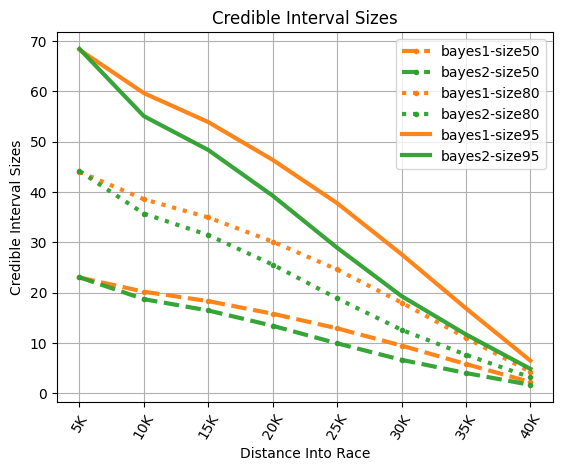

In [22]:
colors = ['C1', 'C2'] * 3
tables = []
for conf, style in [(50, "-."), (80, "--."), (95, ":.")]:
    sublabels = [f"bayes1-size{conf}", f"bayes2-size{conf}"]
    table3 = table2.groupby(["dist"])[sublabels].apply(lambda x: (x ** 2).mean() ** 0.5).loc[mks]
    tables.append(table3)

plt.figure(figsize=(30, 20))
big_table = pd.concat(tables, axis=1)
big_table.plot(label=big_table.columns,  style= ["--."] * 2 + [":."] * 2 , linewidth=3, grid=True, alpha=0.95, color=colors)

plt.xlabel("Distance Into Race")
plt.ylabel("Credible Interval Sizes")
plt.xticks(rotation=60)
plt.title("Credible Interval Sizes")
plt.grid(True)
# plt.savefig("analysis/interval_sizes_bayes.png", bbox_inches="tight")


In [23]:
table2

,id,dist,curr_pace,total_pace,finish,age,gender,year,prop,prop2,...,bayes2-size80,bayes2-in80,bayes1-lower95,bayes1-upper95,bayes1-size95,bayes1-in95,bayes2-lower95,bayes2-upper95,bayes2-size95,bayes2-in95
28,286805,5K,5.154639,5.154639,5.018435,31,M,2023,0.118497,0.014042,...,15.676056,True,129.623187,153.451314,23.828127,True,129.923967,153.396527,23.472559,True
71,286848,5K,4.677268,4.677268,4.851115,29,F,2023,0.118497,0.014042,...,18.930600,False,142.738491,171.375227,28.636735,True,142.671183,172.110167,29.438984,True
85,286862,5K,4.897160,4.897160,4.806904,30,M,2023,0.118497,0.014042,...,16.947730,True,136.255268,162.876083,26.620814,True,136.308222,162.570890,26.262668,True
120,286897,5K,5.117707,5.117707,4.720855,41,M,2023,0.118497,0.014042,...,15.597279,True,130.881272,154.911218,24.029946,True,130.724632,154.351121,23.626489,True
125,286902,5K,4.616805,4.616805,4.707687,23,M,2023,0.118497,0.014042,...,19.030079,True,144.270043,174.345303,30.075260,True,144.618285,174.232452,29.614167,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
208126,312707,40K,1.631321,1.960977,1.956008,27,F,2023,0.947980,0.898665,...,7.361881,True,352.769791,367.650515,14.880724,True,355.404688,366.999806,11.595118,True
208138,312719,40K,1.728310,1.967439,1.951665,56,F,2023,0.947980,0.898665,...,7.358283,True,351.485946,366.605673,15.119727,True,353.117800,364.369262,11.251462,True
208148,312729,40K,1.693193,1.959728,1.943664,60,M,2023,0.947980,0.898665,...,7.425018,True,352.759466,368.309526,15.550060,True,354.940887,366.256305,11.315418,True
208150,312731,40K,1.431434,1.968310,1.942322,64,M,2023,0.947980,0.898665,...,7.625386,True,351.187932,366.165688,14.977756,True,356.532759,368.179289,11.646530,True


(0.0, 0.9)

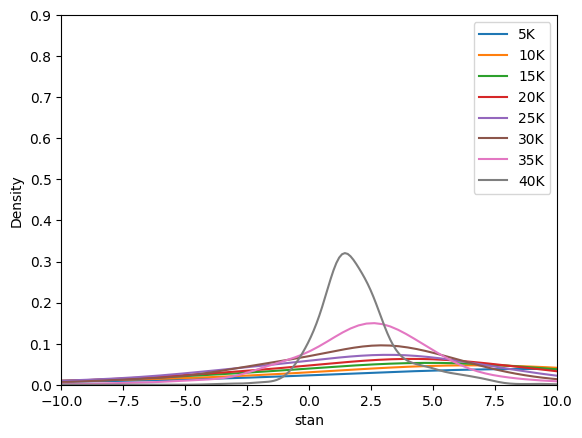

In [24]:
import seaborn as sns
for mk in marks:
    q = table[table["dist"] == mk]
    sns.kdeplot(q["stan"], label=mk)

plt.legend()
plt.xlim(-10, 10)
plt.ylim(0, 0.9)

(0.0, 0.9)

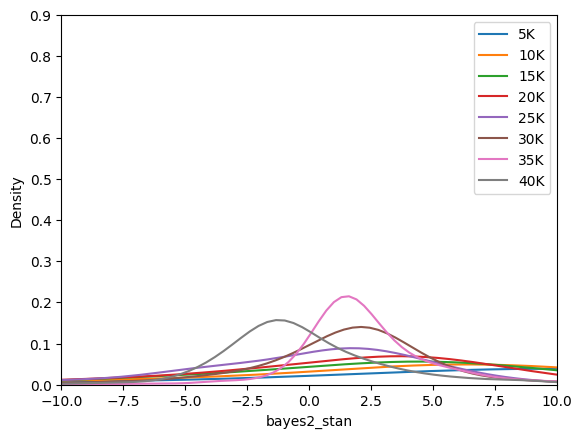

In [29]:
import seaborn as sns
for mk in marks:
    q = table[table["dist"] == mk]
    sns.kdeplot(q["bayes2_stan"], label=mk)

plt.legend()
plt.xlim(-10, 10)
plt.ylim(0, 0.9)

In [31]:
full_preds2

array([[143.49587411, 144.7177591 , 138.74040786, ..., 140.41303026,
        138.39515943, 136.93313032],
       [160.47692961, 156.83296558, 156.61945639, ..., 157.6793122 ,
        165.26019946, 155.33193284],
       [150.17402589, 146.33863773, 147.26911428, ..., 149.89807485,
        141.11228529, 149.02007588],
       ...,
       [359.28408817, 377.71542609, 381.18387334, ..., 388.12182867,
        345.20816228, 329.65817274],
       [383.73026946, 419.56886896, 396.51401223, ..., 439.28568115,
        419.84572493, 369.26860232],
       [413.93927105, 347.71103671, 340.4230486 , ..., 386.53811235,
        351.31392627, 359.83786197]])

In [34]:
np.percentile(full_preds2, [10, 25, 50, 75, 90], axis=1)#.shape

array([[138.07581699, 152.33957908, 145.40296455, ..., 335.64142724,
        348.0329318 , 345.2389518 ],
       [140.25248445, 155.06986556, 147.85315068, ..., 349.61993774,
        362.69556245, 359.74481649],
       [143.12376682, 158.12539278, 150.63977052, ..., 365.87103455,
        380.09899044, 376.40872654],
       [145.63225222, 161.44004536, 153.70329708, ..., 383.64078579,
        399.02233403, 395.86144208],
       [148.05897896, 164.5331896 , 156.36461401, ..., 400.74745679,
        416.5971986 , 415.00120742]])

In [35]:
a1, b1 = np.percentile(full_preds1, [10, 90], axis=1)
a2, b2 = np.percentile(full_preds2, [10, 90], axis=1)

In [36]:
b1 - a1
# b2 - a1

array([10.10473638, 12.78188637, 11.28585729, ..., 69.37630153,
       69.77026436, 79.27883551])

<Axes: ylabel='Density'>

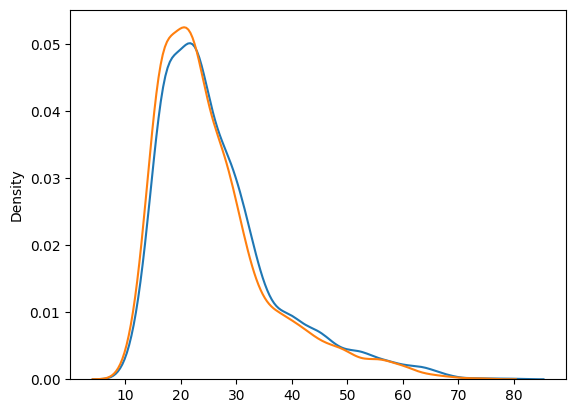

In [39]:
import seaborn as sns
sns.kdeplot(b1 - a1)
sns.kdeplot(b2 - a2)

In [62]:
from reg_models import get_quants
def add_intervals_to_test(test_data_load, fp1, fp2):
    test_data1 = test_data_load.copy()
    for conf, lower, upper in [(50, 25, 75), (80, 10, 90), (95, 2.5, 97.5)]:
        test_true = (42195 / 60) / test_data1["finish"]
        b11, b12 = np.percentile(full_preds1, [lower, upper], axis=1)
        test_data1[f"bayes1-lower{conf}"] = b11
        test_data1[f"bayes1-upper{conf}"] = b12
        test_data1[f"bayes1-size{conf}"] = b12 - b11
        test_data1[f"bayes1-in{conf}"] = (test_true < b12) & (test_true > b11)

        b21, b22 = np.percentile(full_preds2, [lower, upper], axis=1)
        test_data1[f"bayes2-lower{conf}"] = b21
        test_data1[f"bayes2-upper{conf}"] = b22
        test_data1[f"bayes2-size{conf}"] = b22 - b21
        test_data1[f"bayes2-in{conf}"] = (test_true < b22) & (test_true > b21)

        q11, q12 = get_quants(train, test, formula="finish ~ total_pace + dist", quantiles=[lower, upper])
        test_data1[f"quant1-lower{conf}"] = q11
        test_data1[f"quant1-upper{conf}"] = q12
        test_data1[f"quant1-size{conf}"] = q12 - q11
        test_data1[f"quant1-in{conf}"] = (test_true < q12) & (test_true > q11)

        q21, q22 = get_quants(train, test, formula="finish ~ total_pace + curr_pace + dist", quantiles=[lower, upper])
        test_data1[f"quant2-lower{conf}"] = q21
        test_data1[f"quant2-upper{conf}"] = q22
        test_data1[f"quant2-size{conf}"] = q22 - q21
        test_data1[f"quant2-in{conf}"] = (test_true < q22) & (test_true > q21)

    return test_data1

test_wor = add_intervals_to_test(test, full_preds1, full_preds2)#, q1, q2)

In [63]:
test_wor

,id,dist,curr_pace,total_pace,finish,age,gender,year,prop,prop2,...,bayes2-size95,bayes2-in95,quant1-lower95,quant1-upper95,quant1-size95,quant1-in95,quant2-lower95,quant2-upper95,quant2-size95,quant2-in95
28,286805,5K,5.154639,5.154639,5.018435,31,M,2023,0.118497,0.014042,...,15.208999,True,133.428227,158.260074,24.831847,True,133.500927,158.484235,24.983307,True
71,286848,5K,4.677268,4.677268,4.851115,29,F,2023,0.118497,0.014042,...,19.173150,False,146.812855,176.415161,29.602307,False,146.871109,176.606155,29.735046,False
85,286862,5K,4.897160,4.897160,4.806904,30,M,2023,0.118497,0.014042,...,16.945293,True,140.328647,167.560913,27.232266,True,140.394393,167.769591,27.375198,True
120,286897,5K,5.117707,5.117707,4.720855,41,M,2023,0.118497,0.014042,...,15.645775,True,134.376013,159.530214,25.154201,True,134.447820,159.752447,25.304627,True
125,286902,5K,4.616805,4.616805,4.707687,23,M,2023,0.118497,0.014042,...,19.493481,False,148.702203,179.016252,30.314049,True,148.758100,179.201505,30.443405,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
208126,312707,40K,1.631321,1.960977,1.956008,27,F,2023,0.947980,0.898665,...,102.446425,True,357.487165,360.325508,2.838343,True,358.370401,381.292433,22.922032,True
208138,312719,40K,1.728310,1.967439,1.951665,56,F,2023,0.947980,0.898665,...,97.251460,True,356.308978,359.186207,2.877229,False,355.822065,372.875053,17.052988,True
208148,312729,40K,1.693193,1.959728,1.943664,60,M,2023,0.947980,0.898665,...,101.342584,True,357.715772,360.546534,2.830762,False,357.638062,376.486890,18.848828,True
208150,312731,40K,1.431434,1.968310,1.942322,64,M,2023,0.947980,0.898665,...,107.796597,True,356.150716,359.033145,2.882430,False,360.195605,397.275439,37.079834,True


In [ ]:
colors = ['C3', 'C4'] * 3
tables = []
for conf, style in [(50, "-."), (80, "--."), (95, ":.")]:
    sublabels = [f"quant1-in{conf}", f"quant2-in{conf}"]
    table = test.groupby(["dist"])[sublabels].apply(lambda x: np.sum(x) / len(x)).loc[mks]
    tables.append(table)

plt.figure(figsize=(40, 40))
big_table = pd.concat(tables, axis=1)
big_table.plot(label=big_table.columns,  style=["-."] * 2 + ["--."] * 2 + [":."] * 2 , linewidth=3, grid=True, alpha=0.75, color=colors)
plt.ylim(0.2, 1) 

plt.xlabel("Distance Into Race")
plt.ylabel("Proportion of Actual Finish Times Within Credible Interval")
plt.xticks(rotation=60)
plt.title("Proportion Within Interval Over Different Distances - Quantile")
plt.grid(True)
plt.legend()
# plt.savefig("analysis/interval_check_quant.png", bbox_inches="tight")

In [ ]:
# import arviz as az
# idata = az.from_netcdf("save_idata.nc")